# Projeto de Bloco - Regressão Linear

**Giuliano Mantovi**

___

## Dataset Escolhido

O dataset escolhido é **Uber Fares Dataset** da plataforma Kaggle.

Link: *https://www.kaggle.com/datasets/yasserh/uber-fares-dataset*

## Objetivo

O objetivo do projeto é tentar prever o preço de uma corrida no uber através de uma regressão linear com base nas coordenadas geográficas de início e final da viagem e com a data e horário da viagem.

In [3]:
import pandas as pd
import pandera as pa

In [26]:
uber = pd.read_csv("uber.csv", index_col="Unnamed: 0")

# Convertendo as colunas com datas para datetime64[ns]
uber["key"] = pd.to_datetime(uber["key"])
uber["pickup_datetime"] = pd.to_datetime(uber["pickup_datetime"]).dt.tz_localize(None)

uber

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
24238194,2015-05-07 19:52:06.000000300,7.5,2015-05-07 19:52:06,-73.999817,40.738354,-73.999512,40.723217,1
27835199,2009-07-17 20:04:56.000000200,7.7,2009-07-17 20:04:56,-73.994355,40.728225,-73.994710,40.750325,1
44984355,2009-08-24 21:45:00.000000610,12.9,2009-08-24 21:45:00,-74.005043,40.740770,-73.962565,40.772647,1
25894730,2009-06-26 08:22:21.000000100,5.3,2009-06-26 08:22:21,-73.976124,40.790844,-73.965316,40.803349,3
17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00,-73.925023,40.744085,-73.973082,40.761247,5
...,...,...,...,...,...,...,...,...
42598914,2012-10-28 10:49:00.000000530,3.0,2012-10-28 10:49:00,-73.987042,40.739367,-73.986525,40.740297,1
16382965,2014-03-14 01:09:00.000000800,7.5,2014-03-14 01:09:00,-73.984722,40.736837,-74.006672,40.739620,1
27804658,2009-06-29 00:42:00.000000780,30.9,2009-06-29 00:42:00,-73.986017,40.756487,-73.858957,40.692588,2
20259894,2015-05-20 14:56:25.000000400,14.5,2015-05-20 14:56:25,-73.997124,40.725452,-73.983215,40.695415,1


## Validações

### Verificações Necessárias

- Latitude varia de -90° ate 90°;
- Longitude varia de -180° até 180°;
- Não deve haver nenhum valor em branco (não preenchido);
- O número de passageiros deve ser no mínimo 1;

In [5]:
# Listando os problemas do dataset

latitude_check = pa.Check.between(-90,90)
longitude_check = pa.Check.between(-180,180)
passenger_count_check = pa.Check.greater_than(0)

schema = pa.DataFrameSchema(
    {
        "key": pa.Column(pa.DateTime, nullable=False),
        "fare_amount": pa.Column(pa.Float, nullable=False),
        "pickup_datetime": pa.Column(pa.DateTime, nullable=False),
        "pickup_longitude": pa.Column(pa.Float, nullable=False, checks=[longitude_check]),
        "pickup_latitude": pa.Column(pa.Float, nullable=False, checks=[latitude_check]),
        "dropoff_longitude": pa.Column(pa.Float, nullable=False, checks=[longitude_check]),
        "dropoff_latitude": pa.Column(pa.Float, nullable=False, checks=[latitude_check]),
        "passenger_count": pa.Column(pa.Int, nullable=False, checks=[passenger_count_check]),
    },
)

In [6]:
try:
    schema.validate(uber, lazy=True)
except pa.errors.SchemaErrors as err:
    print("Falhas nos dados:")
    print(err)

Falhas nos dados:
Schema None: A total of 7 schema errors were found.

Error Counts
------------
- SchemaErrorReason.SCHEMA_COMPONENT_CHECK: 7

Schema Error Summary
--------------------
                                                                                                                             failure_cases  n_failure_cases
schema_context column            check                                                                                                                     
Column         dropoff_latitude  in_range(-90, 90)                                     [872.6976279999999, -881.9855130000001, 493.533332]                3
                                 not_nullable                                                                                        [nan]                1
               dropoff_longitude in_range(-180, 180)                                  [-737.9166650000001, -3356.6663, 1153.5726029999998]                3
                                 n

### Problemas Identificados:

- Três linhas com a latitude de chegada inválida;
- Uma linha sem a latitude de chegada;
- Três linhas com a longitude de chegada inválida;
- Uma linha sem a longitude de chegada;
- Uma linha com o número de passageiros igual a 0;
- Quatro linhas com a latitude de partida inválida;
- Sete linhas com a longitude de partida inválida;

### Solução

- As latitudes e longitudes serão usadas para calcular a distância da viagem então deve-se eliminar as linhas com problemas nesses campos.
- Uma corrida de uber deve ter pelo menos um passageiro portanto desconsidera-se a viagem feita sem passageiros.

In [7]:
# Copiando o schema para eliminar as linhas com problema

latitude_check = pa.Check.between(-90,90)
longitude_check = pa.Check.between(-180,180)
passenger_count_check = pa.Check.greater_than(0)

schema_drop = pa.DataFrameSchema(
    {
        "key": pa.Column(pa.DateTime, nullable=False),
        "fare_amount": pa.Column(pa.Float, nullable=False),
        "pickup_datetime": pa.Column(pa.DateTime, nullable=False),
        "pickup_longitude": pa.Column(pa.Float, nullable=False, checks=[longitude_check]),
        "pickup_latitude": pa.Column(pa.Float, nullable=False, checks=[latitude_check]),
        "dropoff_longitude": pa.Column(pa.Float, nullable=False, checks=[longitude_check]),
        "dropoff_latitude": pa.Column(pa.Float, nullable=False, checks=[latitude_check]),
        "passenger_count": pa.Column(pa.Int, nullable=False, checks=[passenger_count_check]),
    },
    drop_invalid_rows=True,
)

uber_valid = schema_drop.validate(uber, lazy=True)

In [8]:
uber_valid  # Dataframe apenas com as linhas válidas

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
24238194,2015-05-07 19:52:06.000000300,7.5,2015-05-07 19:52:06,-73.999817,40.738354,-73.999512,40.723217,1
27835199,2009-07-17 20:04:56.000000200,7.7,2009-07-17 20:04:56,-73.994355,40.728225,-73.994710,40.750325,1
44984355,2009-08-24 21:45:00.000000610,12.9,2009-08-24 21:45:00,-74.005043,40.740770,-73.962565,40.772647,1
25894730,2009-06-26 08:22:21.000000100,5.3,2009-06-26 08:22:21,-73.976124,40.790844,-73.965316,40.803349,3
17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00,-73.925023,40.744085,-73.973082,40.761247,5
...,...,...,...,...,...,...,...,...
42598914,2012-10-28 10:49:00.000000530,3.0,2012-10-28 10:49:00,-73.987042,40.739367,-73.986525,40.740297,1
16382965,2014-03-14 01:09:00.000000800,7.5,2014-03-14 01:09:00,-73.984722,40.736837,-74.006672,40.739620,1
27804658,2009-06-29 00:42:00.000000780,30.9,2009-06-29 00:42:00,-73.986017,40.756487,-73.858957,40.692588,2
20259894,2015-05-20 14:56:25.000000400,14.5,2015-05-20 14:56:25,-73.997124,40.725452,-73.983215,40.695415,1


## Calculando a Distância Percorrida

In [9]:
from geopy import distance
def calculate_distance(start,end):
    return  distance.distance(start,end).km

distancias = []
for index, row in uber_valid.iterrows():
    start = (row["pickup_latitude"],row["pickup_longitude"])
    end = (row["dropoff_latitude"],row["dropoff_longitude"])
    
    distancia = calculate_distance(start, end)
    
    distancias.append(distancia)

In [10]:
uber_valid["distance"] = distancias

### Avaliando as distâncias calculadas

Várias linhas possuiam erro na latitude ou longitude fazendo com que a viagem fosse de milhares de quilometros. Para evitar o problema consideraremos apenas as viagens menores de 100 km

In [11]:
uber_valid["distance"].describe()

count    199279.000000
mean         20.408857
std         377.863594
min           0.000000
25%           1.215640
50%           2.121956
75%           3.875149
max        8783.593498
Name: distance, dtype: float64

In [12]:
uber_valid[uber_valid["distance"] > 100]  # Distâncias muito grandes devido à falha no registro de latitude e longitude.

uber_100_km = uber_valid[uber_valid["distance"] <= 100]
uber_100_km.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
count,198824.000000,198824.000000,198824.000000,198824.000000,198824.000000,198824.000000,198824.000000
mean,11.358687,-72.581706,39.957327,-72.580767,39.957627,1.690596,3.268800
std,9.893926,10.175163,6.005480,10.175063,6.005656,1.384949,3.722594
min,-52.000000,-75.387785,-74.015515,-75.417737,-74.015750,1.000000,0.000000
25%,6.000000,-73.992074,40.734878,-73.991418,40.733910,1.000000,1.213793
50%,8.500000,-73.981843,40.752622,-73.980119,40.753071,1.000000,2.116867
75%,12.500000,-73.967240,40.767172,-73.963760,40.768017,2.000000,3.855984
max,499.000000,40.808425,45.031653,40.831932,45.031598,208.000000,99.232379


## Regressão Linear

In [13]:
import sklearn.model_selection as ms
import sklearn.linear_model as lm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

/tmp/ipykernel_8044/1645558289.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = uber_100_km.corr()


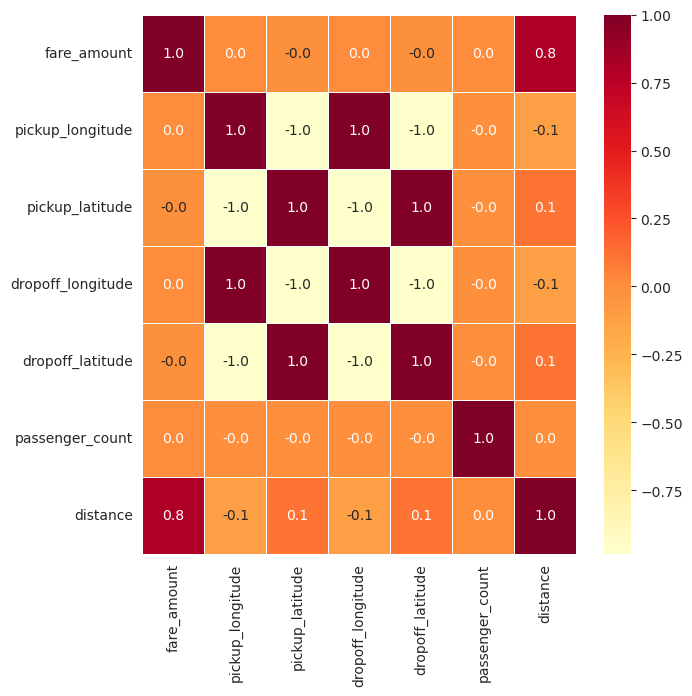

In [14]:
### Matriz de correlacao
corr_matrix = uber_100_km.corr()

fig, axs = plt.subplots(figsize=(7,7))

axs = sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".1f",
    linewidths=0.5,
    cmap="YlOrRd",
)


Única variável que se correlaciona bem com o preço da corrida é a distância

In [16]:
# Separando os conjuntos de treino e teste
x = uber_100_km[["pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude", "passenger_count", "distance"]]
y = uber_100_km["fare_amount"]

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25)

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

regressor = LinearRegression()
regressor.fit(x_train,y_train)  # Treinando o modelo
predict = regressor.predict(x_test) # Fazendo predições

In [21]:
mse = mean_squared_error(y_test, predict)
mae = mean_absolute_error(y_test, predict)

print(f"Erro MSE: {mse}")
print(f"erro MAE: {mae}")

Erro MSE: 33.324555100643124
erro MAE: 2.5489750426924362


## Streamlit App

In [25]:
# Exportando os datasets
uber_valid.to_csv("uber_export.csv")
uber_100_km.to_csv("uber_100_km_export.csv")